# **Using tensorflow framework to training a model for mask detection**

In [ ]:
!nvidia-smi

Mon May 31 17:23:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Import needed libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
import numpy as np

In [ ]:
# Mount the google drive folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Checking the directories
!ls /content/gdrive/MyDrive/Laboratorio\ institucional/DATASET/dataset_24_05_2021

test  train


In [ ]:
# Set up the dataset image folder 
img_folder = '/content/gdrive/MyDrive/Laboratorio institucional/DATASET/dataset_24_05_2021/train'
test_folder = '/content/gdrive/MyDrive/Laboratorio institucional/DATASET/dataset_24_05_2021/test'

In [ ]:
# Setting up batch size and image dimensions
batch_size = 16
img_height = 224
img_width = 224

In [ ]:
# Splitting the dataset in training group and validation group
train_ds = image_dataset_from_directory(
  img_folder,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1100 files belonging to 2 classes.
Using 880 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  img_folder,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1100 files belonging to 2 classes.
Using 220 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_folder,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 150 files belonging to 2 classes.


In [ ]:
# Showing the class names
class_names = train_ds.class_names
print(class_names)

['with_mask', 'without_mask']


(16, 224, 224, 3)


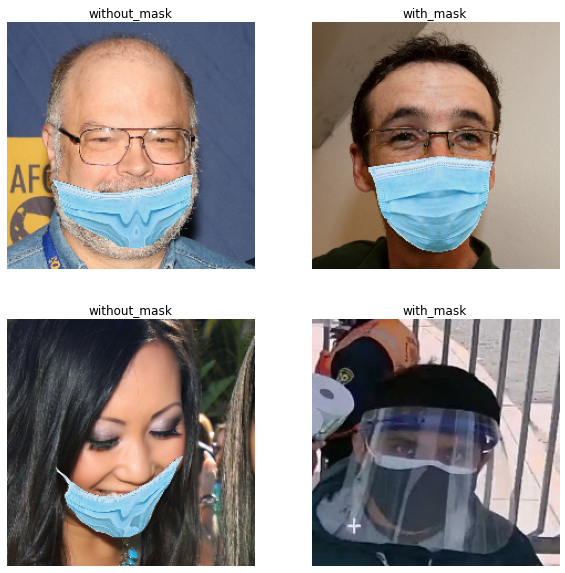

In [ ]:
# Taking some images and displaying them
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(images.shape)
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

##

In [1]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

NameError: ignored

In [ ]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
# normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalizedval__ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

0.0 0.9992373


In [ ]:
# normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_test_ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = normalized_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Building the model**

In [ ]:

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.applications import resnet, VGG16

In [ ]:
def build_model():  
    base_model = VGG16(input_shape=(img_width, img_height, 3),
                                     weights='imagenet',
                                     include_top=False,
                                     pooling='max')
    
    base_model.trainable = False

    x = base_model.output
    #x = Dense(100, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [ ]:
model = build_model()  
opt = tf.keras.optimizers.Adam(0.001, clipnorm=1.0)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
55/55 [==============================] - 8s 138ms/step - loss: 7.0699 - acc: 0.9227 - val_loss: 6.5484 - val_acc: 0.9136
Epoch 2/50
55/55 [==============================] - 8s 136ms/step - loss: 4.9697 - acc: 0.9250 - val_loss: 6.1203 - val_acc: 0.9227
Epoch 3/50
55/55 [==============================] - 8s 137ms/step - loss: 4.3719 - acc: 0.9307 - val_loss: 6.9666 - val_acc: 0.8955
Epoch 4/50
55/55 [==============================] - 8s 137ms/step - loss: 3.2914 - acc: 0.9420 - val_loss: 5.8541 - val_acc: 0.9091
Epoch 5/50
55/55 [==============================] - 8s 137ms/step - loss: 2.5047 - acc: 0.9489 - val_loss: 6.1676 - val_acc: 0.9045
Epoch 6/50
55/55 [==============================] - 8s 137ms/step - loss: 2.3628 - acc: 0.9523 - val_loss: 6.6933 - val_acc: 0.8909
Epoch 7/50
55/55 [==============================] - 8s 137ms/step - loss: 1.9789 - acc: 0.9591 - val_loss: 6.0573 - val_acc: 0.8909
Epoch 8/50
55/55 [==============================] - 8s 138ms/step - loss: 1.

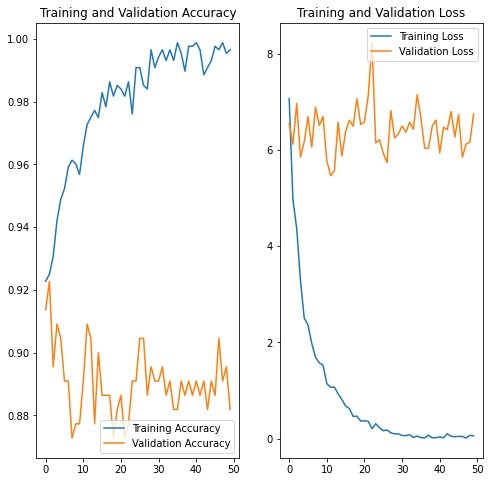

In [ ]:
# Showing the learning curves
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### **Making some predictions**

In [ ]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


In [ ]:
predictions = model.predict(image_batch)

In [ ]:
predictions.astype('int')

array([[0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1]])

In [ ]:
labels_batch.numpy()

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

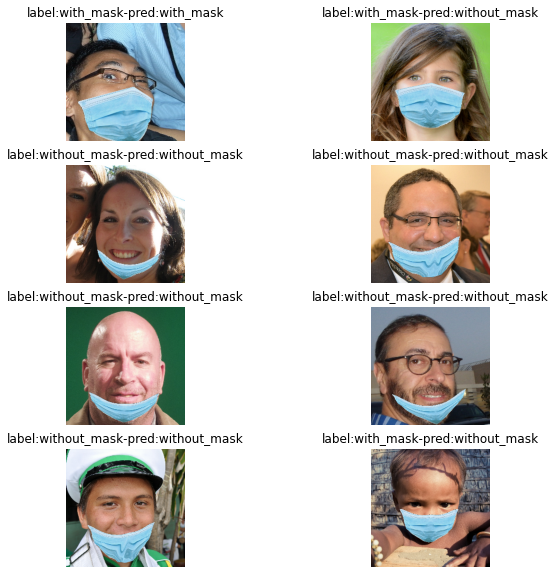

In [ ]:
plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
for i in range(8):
    ax = plt.subplot(4, 2, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='seismic', vmax=1)
    plt.title('label:'+class_names[labels_batch.numpy()[i]]+'-pred:'+class_names[predictions.astype('int')[i][0]])
    plt.axis("off")

### **Evaluating the model**

In [ ]:
model.evaluate(test_ds)

10/10 [==============================] - 1s 69ms/step - loss: 19.2994 - acc: 0.7933


[19.299423217773438, 0.7933333516120911]

In [ ]:
model.save('vgg_test.h5')

In [ ]:
!ls /content/gdrive/MyDrive/Laboratorio\ institucional/DATASET/

'con mascara'	       dataset_24_05_2021   image
'Dataset 24 03 2021'   dataset_facial	   'sin mascara'
